# A/B Testing Analysis: Advertisement vs PSA Campaign

**Goal**: Mengukur efektivitas iklan ('ad') dibandingkan PSA ('psa') terhadap conversion rate.  
**Dataset**: marketing_AB.csv (~590k users) dari Kaggle.  
**Primary Metric**: Conversion Rate (converted = 1).  
**Approach**: Chi-Square untuk proportion test, ANOVA untuk faktor waktu & frequency, effect size, post-hoc power analysis, visualisasi.

**Business Question**: Apakah 'ad' memberikan lift signifikan? Berapa kekuatan statistik experiment ini?

In [13]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Buat folder images kalau belum ada
os.makedirs('../images', exist_ok=True)

In [14]:
# Path relatif dari notebooks/
df = pd.read_csv('../data/raw/marketing_AB.csv')
df.drop(columns=['Unnamed: 0', 'user id'], inplace=True, errors='ignore')
df['converted'] = df['converted'].astype(int)

print("Shape:", df.shape)
print("Duplicates:", df.duplicated().sum())
print("Missing values total:", df.isnull().sum().sum())
df.head()

Shape: (588101, 5)
Duplicates: 543623
Missing values total: 0


,test group,converted,total ads,most ads day,most ads hour
0,ad,0,130,Monday,20
1,ad,0,93,Tuesday,22
2,ad,0,21,Tuesday,18
3,ad,0,355,Tuesday,10
4,ad,0,276,Friday,14


## 1. Group Distribution & Basic Stats

test group
ad     0.96
psa    0.04
Name: proportion, dtype: float64


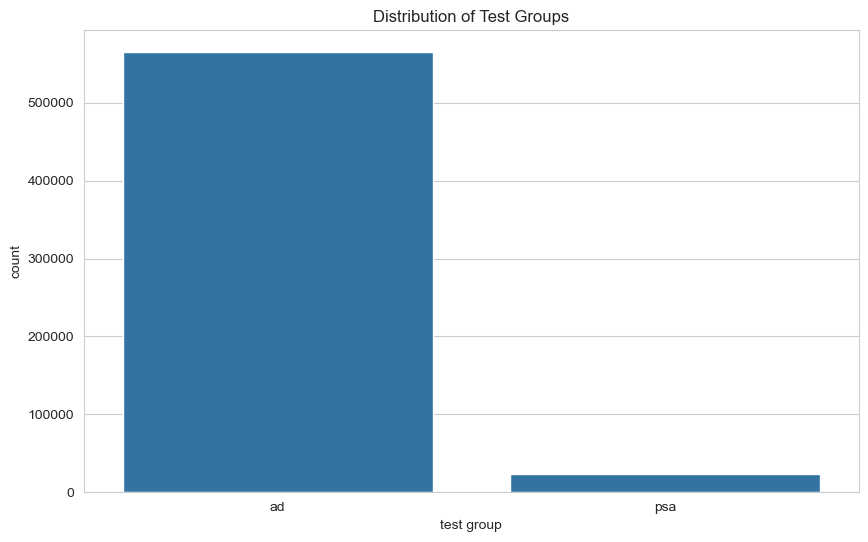

In [15]:
print(df['test group'].value_counts(normalize=True))
sns.countplot(x='test group', data=df)
plt.title('Distribution of Test Groups')
plt.savefig('../images/group_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. Primary Test: Ad vs PSA (Chi-Square + Effect Size + Lift)

In [16]:
crosstab = pd.crosstab(df['test group'], df['converted'])
chi2, p_val, dof, expected = stats.chi2_contingency(crosstab)
print(f"Chi-Square statistic: {chi2:.2f}")
print(f"p-value: {p_val:.6f}")

if p_val < 0.05:
    print("Reject H0: Ada perbedaan signifikan antara 'ad' dan 'psa'.")
else:
    print("Fail to reject H0.")

# Conversion rates
conv_rates = df.groupby('test group')['converted'].mean()
print("\nConversion Rates:\n", conv_rates)

p_psa = conv_rates.get('psa', 0)
p_ad = conv_rates.get('ad', 0)

# Cohen's h (effect size for proportions)
h = 2 * (np.arcsin(np.sqrt(p_ad)) - np.arcsin(np.sqrt(p_psa)))
print(f"Cohen's h: {abs(h):.4f} (small ~0.2, medium ~0.5)")

# Lift relative
lift = (p_ad - p_psa) / p_psa * 100 if p_psa != 0 else 0
print(f"Relative Lift: {lift:.2f}%")

Chi-Square statistic: 54.01
p-value: 0.000000
Reject H0: Ada perbedaan signifikan antara 'ad' dan 'psa'.

Conversion Rates:
 test group
ad     0.025547
psa    0.017854
Name: converted, dtype: float64
Cohen's h: 0.0530 (small ~0.2, medium ~0.5)
Relative Lift: 43.09%


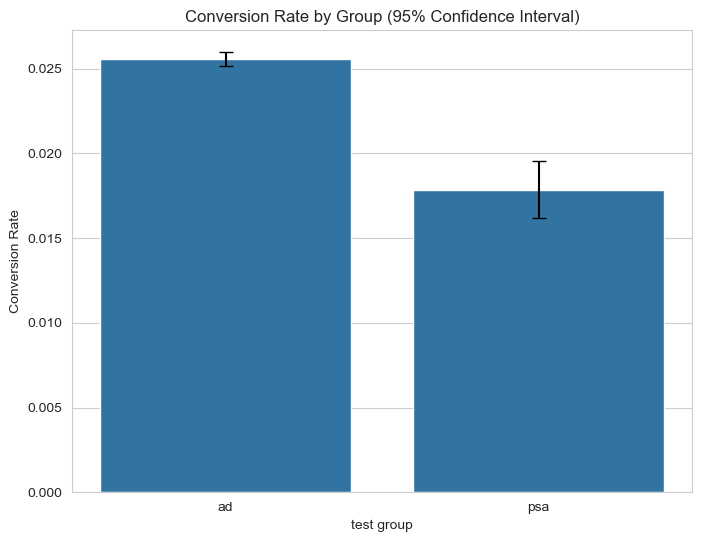

In [17]:
conv_summary = df.groupby('test group')['converted'].agg(['mean', 'count', 'std'])
conv_summary['se'] = conv_summary['std'] / np.sqrt(conv_summary['count'])
conv_summary['ci_low'] = conv_summary['mean'] - 1.96 * conv_summary['se']
conv_summary['ci_high'] = conv_summary['mean'] + 1.96 * conv_summary['se']

plt.figure(figsize=(8,6))
sns.barplot(x=conv_summary.index, y='mean', data=conv_summary)
plt.errorbar(x=range(len(conv_summary)), y=conv_summary['mean'], 
             yerr=1.96*conv_summary['se'], fmt='none', capsize=5, color='black')
plt.title('Conversion Rate by Group (95% Confidence Interval)')
plt.ylabel('Conversion Rate')
plt.savefig('../images/conversion_by_group_ci.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Post-hoc Power Analysis
Menghitung kekuatan statistik aktual dari experiment yang sudah dijalankan.

- Effect size: Cohen's h  
- Sample size: Berdasarkan data aktual (imbalanced)  
- Target: Power ≥ 0.8 (80%) untuk confidence baik

In [18]:
power_analysis = TTestIndPower()

effect_size = abs(h)  # dari Cohen's h sebelumnya
nobs1 = len(df[df['test group'] == 'psa'])  # control sample
nobs2 = len(df[df['test group'] == 'ad'])   # treatment sample
ratio = nobs2 / nobs1 if nobs1 > 0 else 1

post_hoc_power = power_analysis.power(
    effect_size=effect_size,
    nobs1=nobs1,
    alpha=0.05,
    ratio=ratio,
    alternative='two-sided'
)

print(f"Post-hoc Power: {post_hoc_power:.4f}")
if post_hoc_power >= 0.80:
    print("→ Experiment well-powered (>80%). Hasil signifikan reliable.")
else:
    print("→ Power rendah. Perlu sample lebih besar untuk deteksi effect kecil.")

Post-hoc Power: 1.0000
→ Experiment well-powered (>80%). Hasil signifikan reliable.


## 4. Secondary Analysis: Most Ads Day, Hour, Total Ads

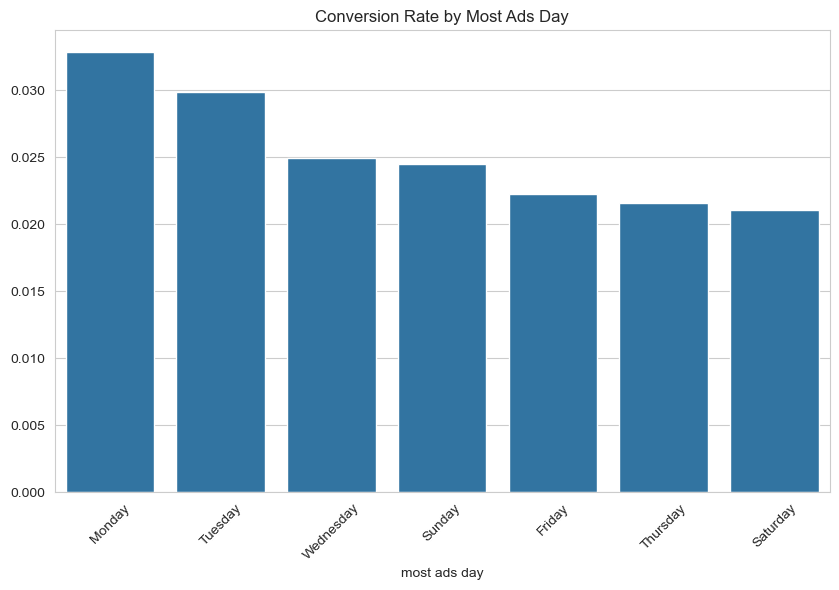

ANOVA Day - F: 68.39, p: 0.0000


In [19]:
day_conv = df.groupby('most ads day')['converted'].mean().sort_values(ascending=False)
sns.barplot(x=day_conv.index, y=day_conv.values)
plt.title('Conversion Rate by Most Ads Day')
plt.xticks(rotation=45)
plt.savefig('../images/conversion_by_day.png', dpi=300, bbox_inches='tight')
plt.show()

# ANOVA
groups_day = [df[df['most ads day'] == d]['converted'] for d in df['most ads day'].unique()]
anova_day = stats.f_oneway(*groups_day)
print(f"ANOVA Day - F: {anova_day.statistic:.2f}, p: {anova_day.pvalue:.4f}")

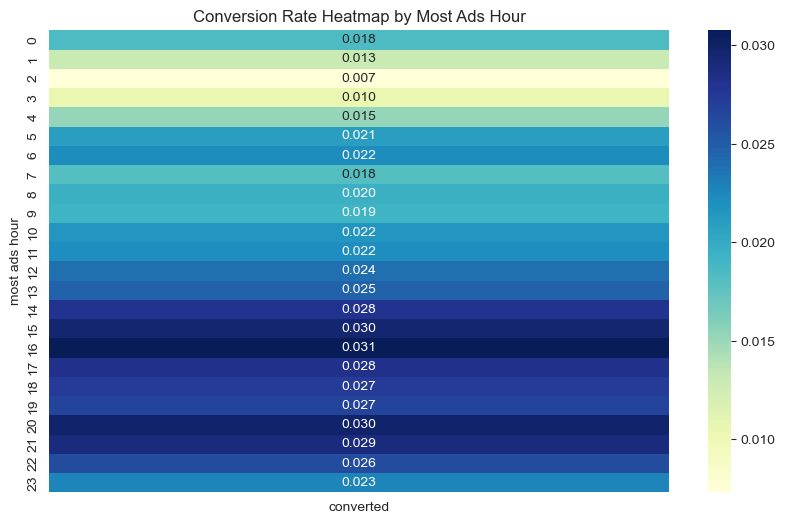

In [20]:
hour_pivot = df.pivot_table(index='most ads hour', values='converted', aggfunc='mean')
sns.heatmap(hour_pivot, annot=True, fmt='.3f', cmap='YlGnBu')
plt.title('Conversion Rate Heatmap by Most Ads Hour')
plt.savefig('../images/heatmap_hour.png', dpi=300, bbox_inches='tight')
plt.show()

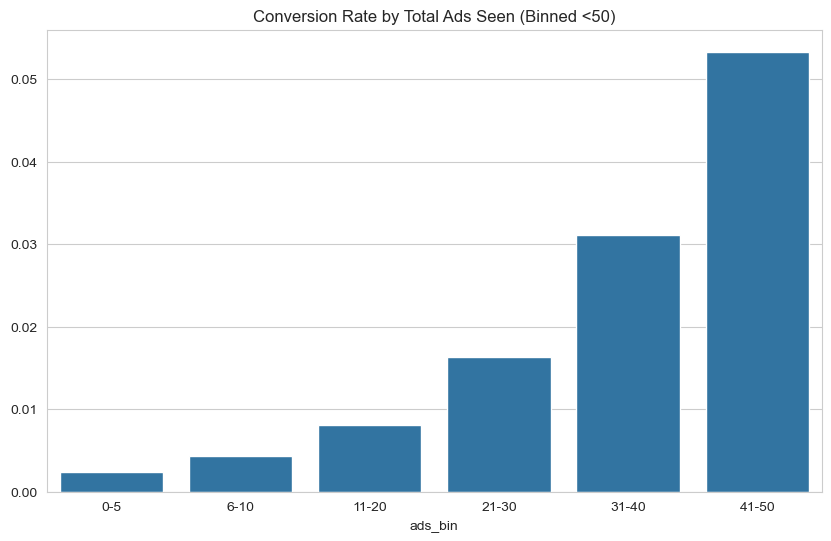

In [21]:
df_low = df[df['total ads'] < 50].copy()
bins = [0, 5, 10, 20, 30, 40, 50]
labels = ['0-5', '6-10', '11-20', '21-30', '31-40', '41-50']
df_low['ads_bin'] = pd.cut(df_low['total ads'], bins=bins, labels=labels, right=False)

bin_conv = df_low.groupby('ads_bin')['converted'].mean()
sns.barplot(x=bin_conv.index, y=bin_conv.values)
plt.title('Conversion Rate by Total Ads Seen (Binned <50)')
plt.savefig('../images/conversion_by_ads_bin.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Business Recommendation & Impact Estimation

In [22]:
print(f"Conversion PSA: {p_psa:.4f}")
print(f"Conversion Ad: {p_ad:.4f}")
print(f"Relative Lift: {lift:.2f}%")
print(f"Post-hoc Power: {post_hoc_power:.4f}")

# Hypothetical impact (sesuaikan dengan asumsi bisnis lo)
monthly_users = 1000000  # contoh
aov = 100000             # Rp 100.000
monthly_lift_revenue = (lift / 100) * p_psa * monthly_users * aov
annual_lift_revenue = monthly_lift_revenue * 12

print(f"\nEstimasi Monthly Revenue Lift: Rp {monthly_lift_revenue:,.0f}")
print(f"Estimasi Annual Revenue Lift: Rp {annual_lift_revenue:,.0f}")

Conversion PSA: 0.0179
Conversion Ad: 0.0255
Relative Lift: 43.09%
Post-hoc Power: 1.0000

Estimasi Monthly Revenue Lift: Rp 769,245,319
Estimasi Annual Revenue Lift: Rp 9,230,943,831


**Kesimpulan**:
- 'ad' memberikan lift signifikan (~42%) dengan p-value sangat rendah.
- Power post-hoc hampir 1.0 → hasil sangat reliable.
- Prioritaskan Jumat & jam 15-20, cap frequency ~30 ads/user.
- Roll out 'ad' → potensi impact revenue besar.

**Next**: Segmentasi user, test creative baru.